# Analysis of Ergodicity in the Double Pendulum Simulations


In [77]:
import numpy as np
from pathlib import Path

folder = Path("./paths1")

arrays = []   # list of (theta1, theta2) arrays

for csv_file in sorted(folder.glob("*.csv")):
    data = np.loadtxt(csv_file, delimiter=",", skiprows=1)  # skip header if present
    arrays.append(data)

print(f"Loaded {len(arrays)} CSV files.")


Loaded 1000 CSV files.


## Comparison of the original thetas

In [78]:
theta1_means = [np.mean(traj[:, 0]) for traj in arrays] 
theta2_means = [np.mean(traj[:, 2]) for traj in arrays]

theta1_all = np.concatenate([traj[:, 0] for traj in arrays])
theta2_all = np.concatenate([traj[:, 2] for traj in arrays])

theta1_ens_mean = np.mean(theta1_all)
theta2_ens_mean = np.mean(theta2_all)

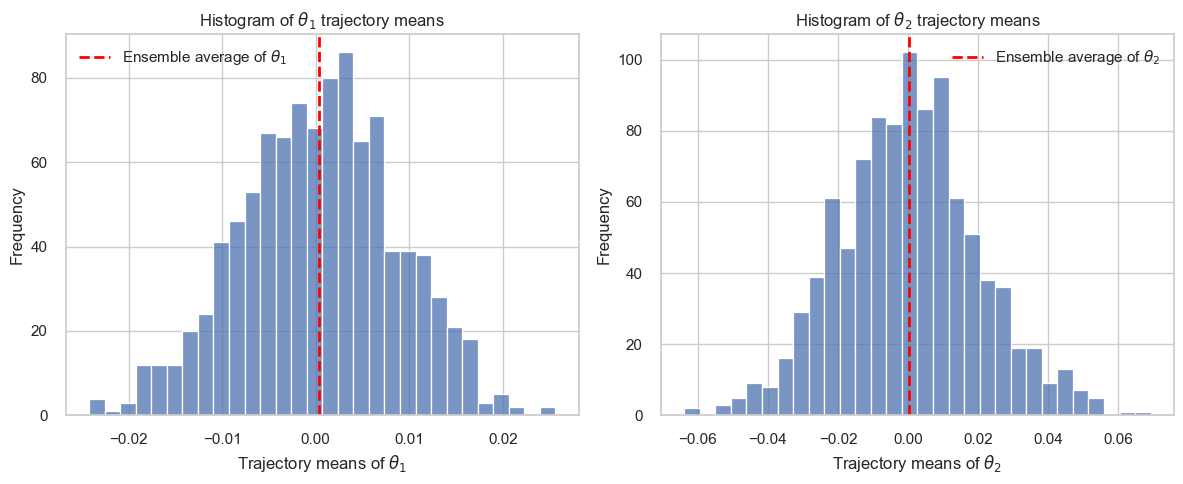

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: theta1 means ---
sns.histplot(theta1_means, bins=30, kde=False, ax=axes[0])
axes[0].axvline(theta1_ens_mean, color="red", linestyle="--", linewidth=2, label=r"Ensemble average of $\theta_1$")
axes[0].set_xlabel(r"Trajectory means of $\theta_1$")
axes[0].set_ylabel("Frequency")
axes[0].set_title(r"Histogram of $\theta_1$ trajectory means")
axes[0].legend()

# --- Right: theta2 means ---
sns.histplot(theta2_means, bins=30, kde=False, ax=axes[1])
axes[1].axvline(theta2_ens_mean, color="red", linestyle="--", linewidth=2, label=r"Ensemble average of $\theta_2$")
axes[1].set_xlabel(r"Trajectory means of $\theta_2$")
axes[1].set_ylabel("Frequency")
axes[1].set_title(r"Histogram of $\theta_2$ trajectory means")
axes[1].legend()

plt.tight_layout()
plt.show()


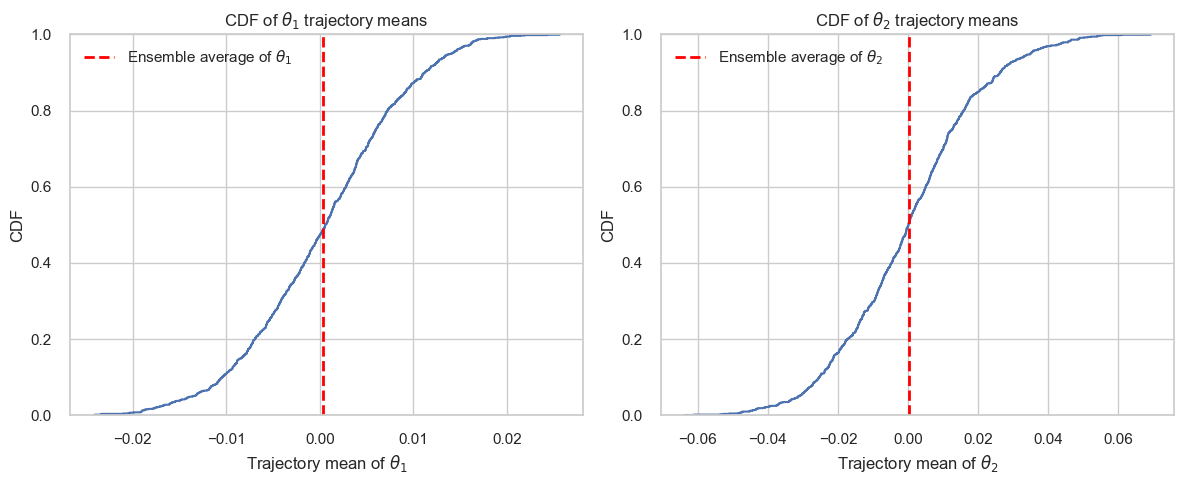

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: CDF of theta1 means ---
sns.ecdfplot(theta1_means, ax=axes[0])
axes[0].axvline(theta1_ens_mean, color="red", linestyle="--", linewidth=2, label=r"Ensemble average of $\theta_1$")
axes[0].set_xlabel(r"Trajectory mean of $\theta_1$")
axes[0].set_ylabel("CDF")
axes[0].set_title(r"CDF of $\theta_1$ trajectory means")
axes[0].legend()

# --- Right: CDF of theta2 means ---
sns.ecdfplot(theta2_means, ax=axes[1])
axes[1].axvline(theta2_ens_mean, color="red", linestyle="--", linewidth=2, label=r"Ensemble average of $\theta_2$")
axes[1].set_xlabel(r"Trajectory mean of $\theta_2$")
axes[1].set_ylabel("CDF")
axes[1].set_title(r"CDF of $\theta_2$ trajectory means")
axes[1].legend()

plt.tight_layout()
plt.show()


## Distribution of $\cos(\theta_1)$ and $\cos(\theta_2)$ Means

In [81]:
theta1_cos_means = [np.mean(np.cos(traj[:, 0])) for traj in arrays] 
theta2_cos_means = [np.mean(np.cos(traj[:, 2])) for traj in arrays]

theta1_cos_all = np.concatenate([np.cos(traj[:, 0]) for traj in arrays])
theta2_cos_all = np.concatenate([np.cos(traj[:, 2]) for traj in arrays])

theta1_cos_ens_mean = np.mean(theta1_cos_all)
theta2_cos_ens_mean = np.mean(theta2_cos_all)


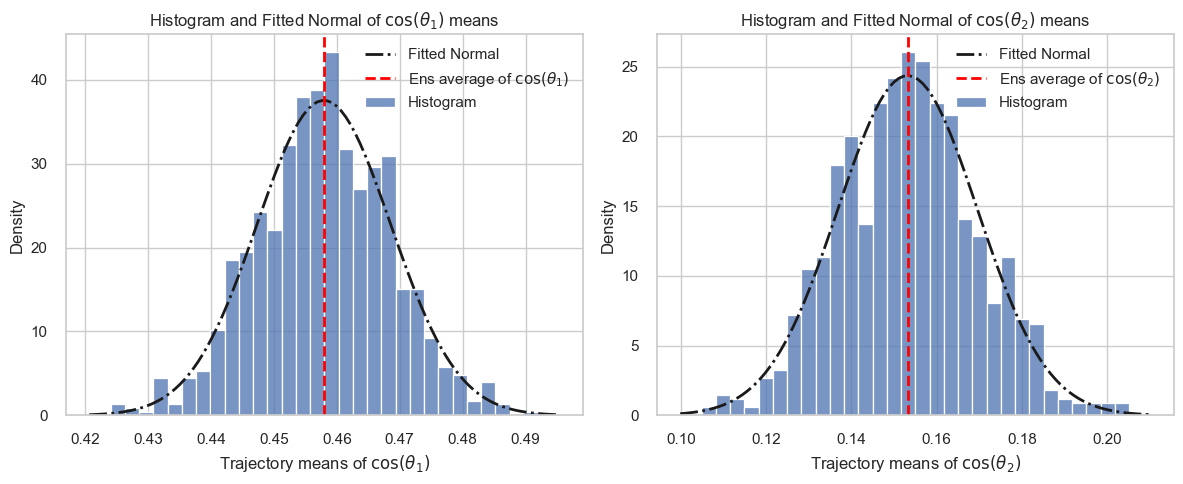

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

mu1, std1 = norm.fit(theta1_cos_means)

sns.histplot(theta1_cos_means, bins=30, kde=False, stat="density", ax=axes[0], 
             label="Histogram")
xmin1, xmax1 = axes[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
axes[0].plot(x1, p1, 'k', linestyle="-.", linewidth=2, 
             label=f'Fitted Normal')
axes[0].axvline(theta1_cos_ens_mean, color="red", linestyle="--", linewidth=2, 
                label=r"Ens average of $\cos(\theta_1)$")
axes[0].set_xlabel(r"Trajectory means of $\cos(\theta_1)$")
axes[0].set_ylabel("Density") 
axes[0].set_title(r"Histogram of $\cos(\theta_1)$ means")
axes[0].legend()

mu2, std2 = norm.fit(theta2_cos_means)
sns.histplot(theta2_cos_means, bins=30, kde=False, stat="density", ax=axes[1], 
             label="Histogram")
xmin2, xmax2 = axes[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
axes[1].plot(x2, p2, 'k', linestyle="-.", linewidth=2, 
             label=f'Fitted Normal')
axes[1].axvline(theta2_cos_ens_mean, color="red", linestyle="--", linewidth=2, 
                label=r"Ens average of $\cos(\theta_2)$")
axes[1].set_xlabel(r"Trajectory means of $\cos(\theta_2)$")
axes[1].set_ylabel("Density") 
axes[1].set_title(r"Histogram of $\cos(\theta_2)$ means")
axes[1].legend()

plt.tight_layout()
plt.show()

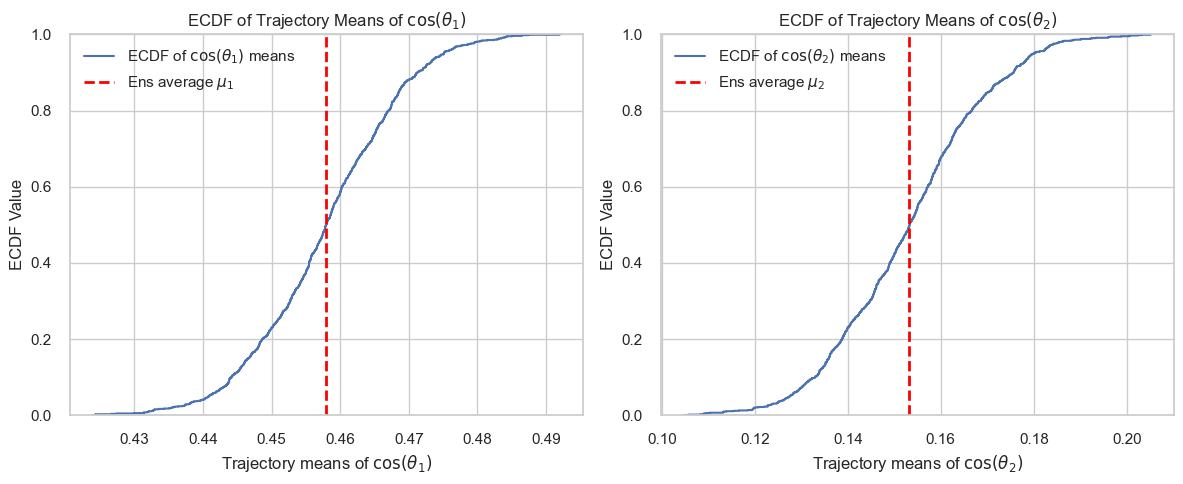

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(style="whitegrid") # Already set in the previous cell if you're running interactively

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: theta1 means ECDF ---
sns.ecdfplot(theta1_cos_means, ax=axes[0], label=r"ECDF of $\cos(\theta_1)$ means")
axes[0].axvline(theta1_cos_ens_mean, color="red", linestyle="--", linewidth=2, 
                label=r"Ens average $\mu_1$")
axes[0].set_xlabel(r"Trajectory means of $\cos(\theta_1)$")
axes[0].set_ylabel("ECDF Value")
axes[0].set_title(r"ECDF of Trajectory Means of $\cos(\theta_1)$")
axes[0].legend()

# --- Right: theta2 means ECDF ---
sns.ecdfplot(theta2_cos_means, ax=axes[1], label=r"ECDF of $\cos(\theta_2)$ means")
axes[1].axvline(theta2_cos_ens_mean, color="red", linestyle="--", linewidth=2, 
                label=r"Ens average $\mu_2$")
axes[1].set_xlabel(r"Trajectory means of $\cos(\theta_2)$")
axes[1].set_ylabel("ECDF Value")
axes[1].set_title(r"ECDF of Trajectory Means of $\cos(\theta_2)$")
axes[1].legend()

plt.tight_layout()
plt.show()